In [1]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# READ CSV

In [2]:
df_original = pd.read_csv("datasets/historical_demand.csv")
df_original.head()

,anio,mes,agente_nemo,agente_descripcion,tipo_agente,region,provincia,categoria_area,categoria_demanda,tarifa,categoria_tarifa,demanda_MWh,indice_tiempo
0,2012,1,AARGTAOY,AEROP ARG 2000 - Aeroparque,GU,GRAN BS.AS.,BUENOS AIRES,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,2222.628,2012-01
1,2012,1,ACARQQ3Y,ASOC.COOP.ARG. - Quequén,GU,BUENOS AIRES,BUENOS AIRES,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,536.858,2012-01
2,2012,1,ACARSLSY,ASOC.COOP.ARG. - San Lorenzo,GU,LITORAL,SANTA FE,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,336.297,2012-01
3,2012,1,ACINROSY,ACINDAR ROSARIO EX-NAVARRO,GU,LITORAL,SANTA FE,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,601.066,2012-01
4,2012,1,ACINTBOY,ACINDAR PTA. TABLADA,GU,GRAN BS.AS.,BUENOS AIRES,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,3076.618,2012-01


We have the demand from different agents in a month but we want the total demand per month.

In [3]:
df_time_series = df_original[['indice_tiempo', 'demanda_MWh']].groupby('indice_tiempo').sum()
df_time_series.index = pd.to_datetime(df_time_series.index)


In [4]:
df_time_series.index.names = ['time_index']

In [5]:
df_time_series.rename(columns={'demanda_MWh': 'demand_MWh'}, inplace=True)

In [6]:
df_time_series.describe()

,demand_MWh
count,9.800000e+01
mean,1.175291e+07
std,1.336332e+06
min,8.969068e+06
25%,1.058506e+07
50%,1.186014e+07
75%,1.268995e+07
max,1.493529e+07


# CHECK GAPS BETWEEN DATES

In [7]:
df_time_series_check_gaps = df_time_series.reset_index()
df_time_series_check_gaps['gap'] = pd.to_datetime(df_time_series_check_gaps['time_index']).sort_values().diff() > pd.to_timedelta('31 days')
df_time_series_check_gaps[df_time_series_check_gaps['gap']]

,time_index,demand_MWh,gap


<AxesSubplot: xlabel='time_index'>

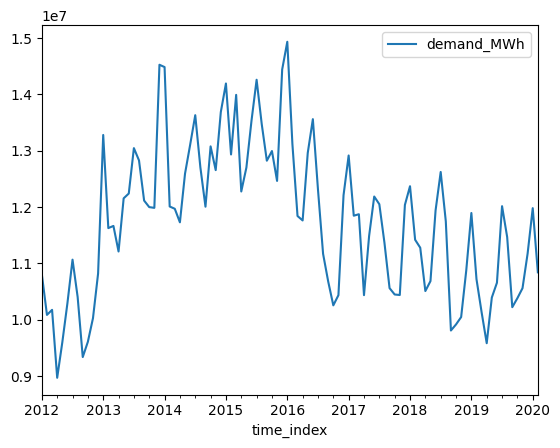

In [8]:
df_time_series.plot()

# FINDING SEASONALITY

In [9]:
df_time_series['four_months_period'] = (utils.four_months_period(df_time_series.index))
df_time_series['six_months_period'] = (utils.six_months_period(df_time_series.index))
df_time_series["year"] = df_time_series.index.year
df_time_series["month"] = df_time_series.index.month
df_time_series["quarter"] = df_time_series.index.quarter

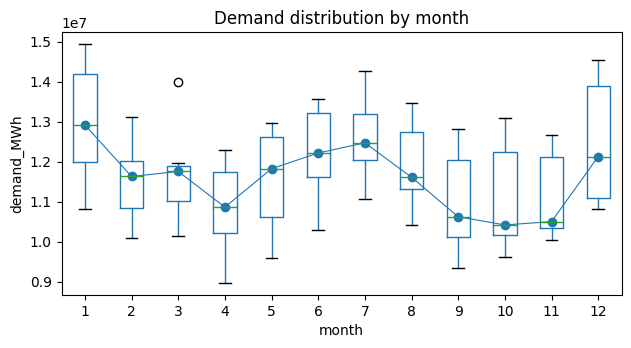

In [10]:
fig, ax = plt.subplots(figsize=(7, 3.5))
df_time_series.boxplot(column='demand_MWh', by='month', ax=ax,)
df_time_series.groupby('month')['demand_MWh'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('demand_MWh')
ax.set_title('Demand distribution by month')
fig.suptitle('');
plt.show()

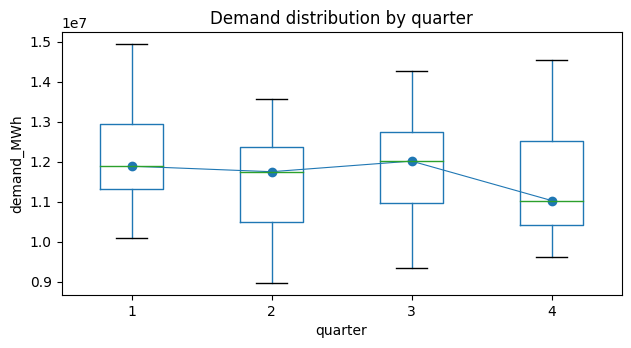

In [11]:
fig, ax = plt.subplots(figsize=(7, 3.5))
df_time_series.boxplot(column='demand_MWh', by='quarter', ax=ax,)
df_time_series.groupby('quarter')['demand_MWh'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('demand_MWh')
ax.set_title('Demand distribution by quarter')
fig.suptitle('');
plt.show()

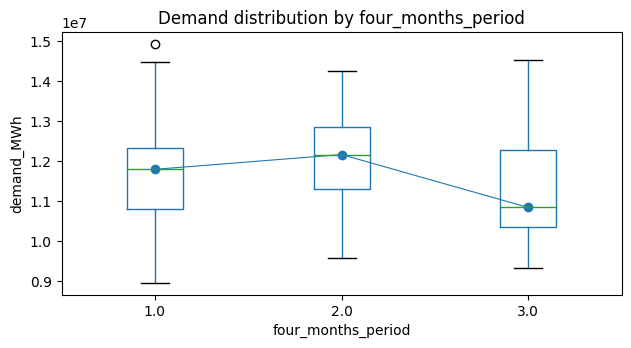

In [12]:
fig, ax = plt.subplots(figsize=(7, 3.5))
df_time_series.boxplot(column='demand_MWh', by='four_months_period', ax=ax,)
df_time_series.groupby('four_months_period')['demand_MWh'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('demand_MWh')
ax.set_title('Demand distribution by four_months_period')
fig.suptitle('');
plt.show()

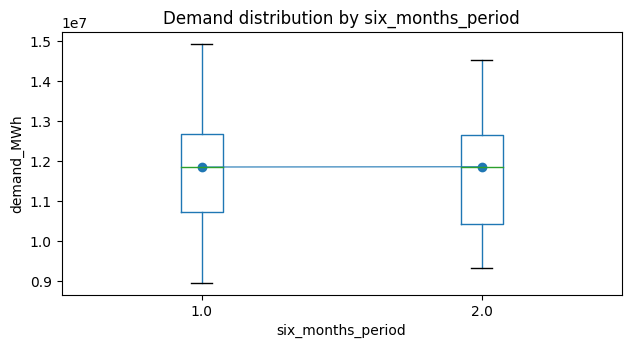

In [13]:
fig, ax = plt.subplots(figsize=(7, 3.5))
df_time_series.boxplot(column='demand_MWh', by='six_months_period', ax=ax,)
df_time_series.groupby('six_months_period')['demand_MWh'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('demand_MWh')
ax.set_title('Demand distribution by six_months_period')
fig.suptitle('');
plt.show()

We can see a clear seasonality of six months period. We drop the rest of periods previously added to the dataset.

In [14]:
df_time_series.drop(columns=['year', 'month', 'quarter', 'four_months_period', 'six_months_period'], inplace=True)

# DECOMPOSE

For decomposing we use two different tools; one from `statsmodels`: `seasonal_decompose` and another from `pmdarima`: `decompose`

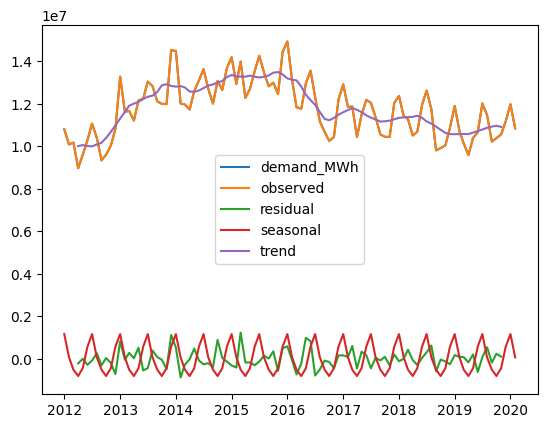

In [15]:
sd = seasonal_decompose(df_time_series['demand_MWh'], period=6)
plt.plot(df_time_series['demand_MWh'])
plt.plot(sd.observed)
plt.plot(sd.resid)
plt.plot(sd.seasonal)
plt.plot(sd.trend)
plt.legend(['demand_MWh', 'observed', 'residual', 'seasonal', 'trend'])
plt.show()

In [16]:
sd2 = pm.arima.decompose(df_time_series.reset_index()['demand_MWh'], type_='additive', m=6)

Text(0.5, 1.0, 'Demand MWh')

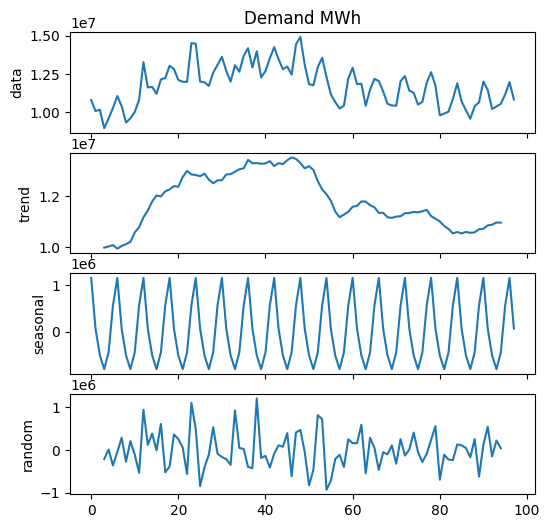

In [17]:
axes = pm.utils.visualization.decomposed_plot(sd2, figure_kwargs={'figsize': (6, 6)}, show = False)
axes[0].set_title("Demand MWh")

# AUTOCORRELATION AND PARTIAL AUTOCORRELATION

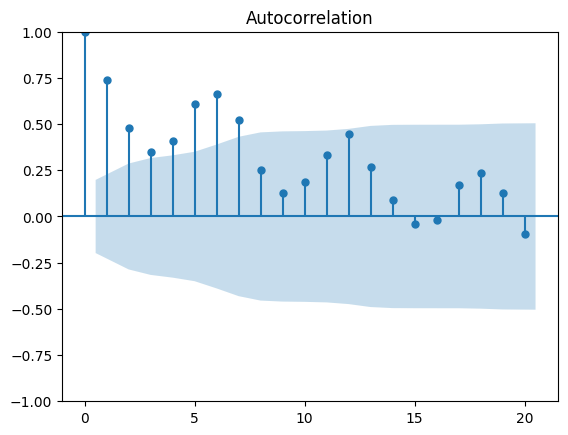

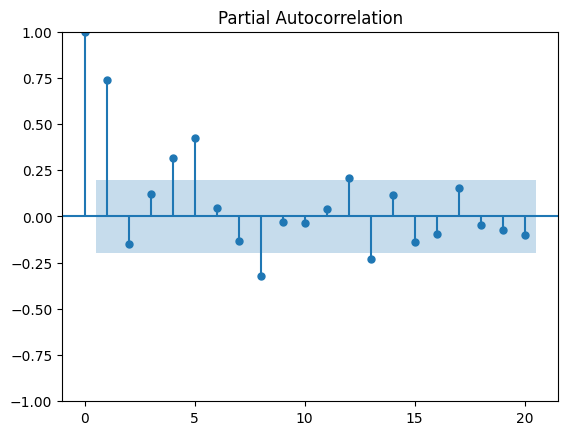

In [18]:
plot_acf(df_time_series['demand_MWh'], lags=20)
plot_pacf(df_time_series['demand_MWh'], lags=20, method="ywm")
plt.show()

In [19]:
df_time_series.to_csv('datasets/historical_demand_sum.csv')